ver3.  
변경사항: crawling 데이터 변경됨(news_df_210205_v03.xlsx → news_df_210222_v04.xlsx)  
기존 EDA 파일 정리사항(dropna, sort(date)) 여기에 반영  
적정 토픽수 도출 CoherenceModel 추가  

# Import

## Import library

In [1]:
import os
import sys
import warnings
from tqdm import tqdm, tqdm_notebook 
import pickle

import numpy as np
import pandas as pd
from tabulate import tabulate

# 데이터 전처리
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab
import rhinoMorph

# 데이터 분석
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

# 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
# import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# function

In [2]:
def setDIR():
    # 현재 jupyter 위치를 PROJECT_DIR 추가
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
    sys.path.insert(0, PROJECT_DIR)
    DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
    print(DATA_DIR)
    
    return DATA_DIR

In [3]:
def cleaningData(data, drop_col_name, sort_col_name):
    '''
    데이터를 정제해주는 함수입니다. 
    1) 기준 column에 None이 존재하는 경우 drop을 진행하고, 정제를 합니다.
    2) 인덱스를 초기화해줍니다.
    
    Parameters: 
    ---------- 
    data : DataFrame
        정제 대상
    drop_col_name : str
        내용이 없는 경우 drop하고 정제할 column의 이름
    sort_col_name : str
        최종 DataFrame의 정렬 기준이 되는 column의 이름
    
    Returns: 
    ------- 
    df : DataFrame
        정제한 데이터
    '''
    df = data.copy()
    print(drop_col_name, '--- None 개수: ', df[drop_col_name].isna().sum())
    print('\n\n=== 제거 데이터 ===\n', tabulate(df.loc[data[drop_col_name].isna()]))
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True) # drop 후 인덱스가 변경되지 않아 index reset 진행
    df[drop_col_name] = df[drop_col_name].apply(lambda x: re.sub(r'[^A-Za-z0-9가-힣 ]','',x.replace('.',' '))) # cleaning
    df.sort_values(by=[sort_col_name], inplace=True) # 정렬
    
    return df

In [4]:
def tokenizeData(text, stopwords, module, option=None):
    '''
    텍스트를 토큰화하고 불용어를 제거하여 문자길이가 2이상인 단어를 추출하는 함수입니다. 
    
    Parameters: 
    ---------- 
    text : str
        토큰화 대상
    stopwords : list[str,...,str]
        불용어 리스트
    module : str
        모듈 입력 가능 리스트 입니다.
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    option : str, default = None
        okt.morphs에 옵션을 추가하는 경우로, 'stem' 또는 'norm'를 입력합니다.
        - stem: 각 단어 어간 추출, norm : 문장정규화
    
    Returns: 
    ------- 
    token : list[str,...,str]
         토큰화된 데이터
    '''

    r = re.compile("okt*")
    isOkt = False
    if r.search(module) is None:
        pass
    else:
        isOkt = True
        
    token = []
    if isOkt:
        okt = Okt()
        if module == 'okt.morphs':
            if option == None:
                token = okt.morphs(text)
            elif option == 'stem':
                token = okt.morphs(text, stem = True)
            elif option == 'norm':
                token = okt.morphs(text, norm = True)
        elif module == 'okt.nouns':
            token = okt.nouns(text)
    elif module == 'mecab.morphs':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.morphs(text)
    elif module == 'mecab.nouns':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.nouns(text)
    elif module == 'rhino':
        # 실질형태소, NNG: 일반명사 / NNP: 고유명사 / VA: 형용사
        rhino = rhinoMorph.startRhino()
        token = rhinoMorph.onlyMorph_list(rhino, text, pos=['NNG','NNP','VA'], combineN=True)
    
    if len(token) > 0:
        token = [word for word in token if word not in stopwords if len(word) > 1]
    
    return token

In [5]:
def display_voca_count(data_series, voca_num=30, figsize=(15,10)):
    '''
    토큰화된 데이터 컬럼의 단어를 카운트하여 출현 빈도수가 높은 순으로 bar 그래프로 보여주는 함수입니다. 
    
    Parameters: 
    ---------- 
    data_series : pandas Series
        토큰화된 데이터
    voca_num : int
        단어 수, default = 30
    figsize : (width, height)
        그래프 사이즈, default = (15,10)
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    
    '''
    
    ds = data_series.copy()
    sorted_keys = ds.apply(lambda x : x[0]).tolist()
    sorted_values = ds.apply(lambda x : x[1]).tolist()

    plt.figure(figsize=figsize)
    plt.rc('font', family='NanumGothic') 
    plt.bar(range(voca_num), sorted_values[:voca_num], color='#9999ff')
    plt.xticks(range(voca_num), sorted_keys[:voca_num], rotation=90)
    plt.show()

In [6]:
def display_cosim(module, data_series, figsize=(15,10)):
    # fit
    bow = module.fit_transform(data_series.astype(str))
    print(module.__class__, ':', bow.shape)

    # cosine similarity
    cos_sim = cosine_similarity(bow,bow)
    print('cos_sim.shape:',cos_sim.shape)
    print('cos_sim:',cos_sim)
    plt.figure(figsize=figsize)
    sns.heatmap(cos_sim)

In [7]:
def get_dict_corpus(data_series):
    
    processed_data = data_series.copy()
    # dictionary : 문서 전체 단어에 대한 정수인코딩
    # corpus : (단어의 정수 인코딩 값,해당 뉴스에서의 해당 단어의 빈도수)
   
    # 정수 인코딩과 빈도수 생성 
    dictionary = corpora.Dictionary(processed_data) 
    # 출현빈도가 적거나 자주 등장하는 단어는 제거 
    dictionary.filter_extremes(no_below=5, no_above=0.05) 
    print('\n\n------\nNumber of unique tokens: %d' % len(dictionary))
    print('type:', type(dictionary),'\n',dictionary)
    
    corpus = [dictionary.doc2bow(text) for text in processed_data] 
    print('\n\nNumber of documents: %d' % len(corpus)) 
    print('corpus type:', type(corpus), ', corpus[0] type:', type(corpus[0]))
          
    return corpus, dictionary

In [8]:
def gensimLDA(data, num_topics):
    corpus, dictionary = get_dict_corpus(data)
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary,  random_state=0) 
    topics = ldamodel.print_topics(num_words=4)
    print('\n\n-- topic --')
    for topic in topics:
        print(topic)
        
    return ldamodel, corpus, dictionary

In [9]:
# 최적의 토픽 수 찾기 
def get_gensim_numtopics(data_series, start=3, limit=12, step=1):
    
    processed_data = data_series.copy()
    corpus, dictionary = get_dict_corpus(processed_data)

    # 최적의 토픽 수 찾기
    coherence_values = [] 
    for num_topics in tqdm_notebook(range(start, limit, step)):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0) 
        coherencemodel = CoherenceModel(model=model, texts=processed_data, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence()) 

#     proper_num = coherence_values.index(max(coherence_values))
    coh_tmp = coherence_values.copy()
    coh_tmp.sort(reverse=True)
    top_values = list(filter(lambda x: x>0.5, coh_tmp))
    proper_num_list = list(map(lambda x: coherence_values.index(x)+start, top_values))
    proper_num_list = proper_num_list[:5]
        
    print('\n\n=== coherence_values ===\n\n', coherence_values)

    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.show()
    
    return proper_num_list

In [10]:
def sklLDA_cntvect(data, num_topics):
    cnt_vect = CountVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)
    cnt_matrix = cnt_vect.fit_transform(data.apply(lambda x : ' '.join(w for w in x)))# cosine similarity - article_origin(CountVectorizer)

    # LDA (LatentDirichletAllocation) : sklearn 제공
    # - n_components 파라미터를 이용해 이 토픽 개수를 조정함
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_topic = lda_model.fit_transform(cnt_matrix)
    feature_names = cnt_vect.get_feature_names()
    print(lda_model.components_.shape)
#     print(lda_model.components_)
    topic_list = get_topic_words(lda_model, feature_names)
    
    return lda_model, cnt_matrix, cnt_vect, topic_list

In [11]:
def sklLDA_tfidf(data, num_topics):
    # TF-IDF Vectorizer : sklearn 제공
    # - max_df: 전체 문서에 걸쳐서 너무 높은 빈도수를 가지는 단어를 제외하기 위함 
    # - min_df: 전체 문서에 걸쳐서 너무 낮은 빈도수를 가지는 단어를 제외하기 위함
    # - max_features : 추출하는 feature의 개수 제한. 정수 지정
    tfidf_vect = TfidfVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)
    tfidf_matrix = tfidf_vect.fit_transform(data_df.token_rhino.apply(lambda x : ' '.join(w for w in x)))

    # LDA (LatentDirichletAllocation) : sklearn 제공
    # - n_components 파라미터를 이용해 이 토픽 개수를 조정함
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_topic = lda_model.fit_transform(tfidf_matrix)
    feature_names = tfidf_vect.get_feature_names()
    print(lda_model.components_.shape)
#     print(lda_model.components_)
    topic_list = get_topic_words(lda_model, feature_names)
    
    return lda_model, tfidf_matrix, tfidf_vect, topic_list

In [12]:
# 각 토픽별로 연관도가 높은 순으로 word 나열
def get_topic_words(model, feature_names, n=20):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #', topic_idx)  # topic num
        tlist = [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[::-1][:n]] # topic 단어, 연관도
        print(tlist)
        topic_list.append(tlist)

    return topic_list

In [13]:
# 현재 jupyter 위치를 PROJECT_DIR 추가
PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
sys.path.insert(0, PROJECT_DIR)
DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
print(DATA_DIR)

C:\Users\lime1\Documents\study\Python\project/data


# main

## import

In [14]:
DATA_DIR = setDIR()

C:\Users\lime1\Documents\study\Python\project/data


In [15]:
data = pd.read_excel(DATA_DIR +'/news_df_210222_v05.xlsx')
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             861 non-null    object
 1   date              861 non-null    object
 2   title             861 non-null    object
 3   article_original  853 non-null    object
 4   url               861 non-null    object
dtypes: object(5)
memory usage: 33.8+ KB


,media,date,title,article_original,url
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...


# 데이터 전처리

## 사용 데이터 정리
기사 본문이 존재하지 않는 8개의 기사는 삭제하고자 합니다.

In [16]:
data_df = cleaningData(data, drop_col_name = 'article_original', sort_col_name = 'date')

article_original --- None 개수:  8


=== 제거 데이터 ===
 ---  --------  ----------  -----------------------------------------------------------------------------------------------------------------------  ---  -------------------------------------------------------------------------------------
157  중앙일보  2020-03-22  민기자야 BTS 기사 쓴 기자가 직접 자기 기사 댓글 읽었다                                                                   nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=025&aid=0002986222
211  조선일보  2020-05-15  사진 BTS RM이 남긴 미술관 방명록쉽지 않은 시기 같이 이겨내요                                                             nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=023&aid=0003531504
405  한겨레    2020-09-02  영상 BTS 빌보드 핫 100 1위온라인 글로벌 기자간담회                                                                       nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=028&aid=0002511264
407  경향신문  2020-09-02  BTS Makes It over the Final Billboard Thres

In [17]:
# 전처리 확인
idx = 8
print('--- cleaning 전 ---\n', data['article_original'].iloc[idx], '\n\n')
print('--- cleaning 후 ---\n', data_df['article_original'].iloc[idx], '\n\n')
data_df.info()

--- cleaning 전 ---
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다. 소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다. 예약판매는 오는 9일부터 진행된다. 앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다. 방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다. 전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다. 빌보드 메인 앨범 차트인 빌보드 200 정상에도 오르며 국외에서도 각종 굵직한 기록을 남겼다. 


--- cleaning 후 ---
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다  소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다  예약판매는 오는 9일부터 진행된다  앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다  방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다  전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다  빌보드 메인 앨범 

# 단어 토큰화

아래 토큰화 시 불용어를 삭제하기 위해 stop word를 파일을 불러옵니다.   
stop word 출처: https://www.ranks.nl/stopwords/korean  

In [18]:
stopwords = open(DATA_DIR+'/stopwords.txt','r', encoding='utf-8').read().split('\n')
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

rhinoMorph 패키지를 사용하며, 불용어와 1글자 이하는 제거합니다.  
※ 주의: konlpy 패키지와 rhinoMorph 패키지를 함께 실행하면 에러가 발생합니다.

In [19]:
# rhino
# 실질형태소, 어말어미(emoi) 제외
# NNG: 일반명사 / NNP: 고유명사 / VA: 형용사 
tqdm.pandas()
rhino = rhinoMorph.startRhino()
data_df['token_rhino'] = data_df.article_original.progress_apply(lambda x: rhinoMorph.onlyMorph_list(rhino, x, pos=['NNG','NNP','VA'], combineN=True))
data_df.token_rhino = data_df.token_rhino.apply(lambda x : [w for w in x if x not in stopwords if len(w) >1])  # 불용어 제거

data_df.head(2)

filepath:  C:\Users\lime1\anaconda3\Lib\site-packages
classpath:  C:\Users\lime1\anaconda3\Lib\site-packages\rhinoMorph/lib/rhino.jar


  0%|                                                                                          | 0/853 [00:00<?, ?it/s]

RHINO started!


100%|████████████████████████████████████████████████████████████████████████████████| 853/853 [00:21<00:00, 39.35it/s]


,media,date,title,article_original,url,token_rhino
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄, 모습, 마지막, 미..."
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄, 미국, 선정, 음악, 변화, 아티스트, 자신, 음악, 장르, 스스로, 재창..."


In [20]:
idx = 8
print('\n === ', idx, ' ===\n')
print('\n-- article_original --\n', data_df['article_original'].iloc[idx])
print('\n-- rhinoMorph --\n', data_df['token_rhino'].iloc[idx])


 ===  8  ===


-- article_original --
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다  소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다  예약판매는 오는 9일부터 진행된다  앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다  방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다  전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다  빌보드 메인 앨범 차트인 빌보드 200 정상에도 오르며 국외에서도 각종 굵직한 기록을 남겼다 

-- rhinoMorph --
 ['그룹', '방탄', '다음', '앨범', '소속사', '빅히트엔터테인먼트', '오전', '커뮤니티', '공지', '오브', '예약판매', '지난해', '방탄소년단', '리더', '미국', '연예매체', '버라이어티', '주최', '시상식', '소식', '새롭', '음악', '새롭', '앨범', '가깝', '미래', '방탄소년단', '앨범', '지난해', '오브', '연작', '앨범', '오브', '이후', '전작', '오브', '페르소나', '판매고', '가온차트', '집계', '시작', '최다', '판매량', '빌보드', '메인', '앨범', '차트', '빌보드', '정상', '국외', '각종', '기록']


# 단어 분포 확인

['방송', '라이브', '생중계', '지구', '그룹', '사회자', '소개', '방탄', '모습', '마지막', '미국', '뉴욕', '맨해튼', '타임스스퀘어', '무대', '현지', '시각', '저녁', '타임스스퀘어', '드롭대형']


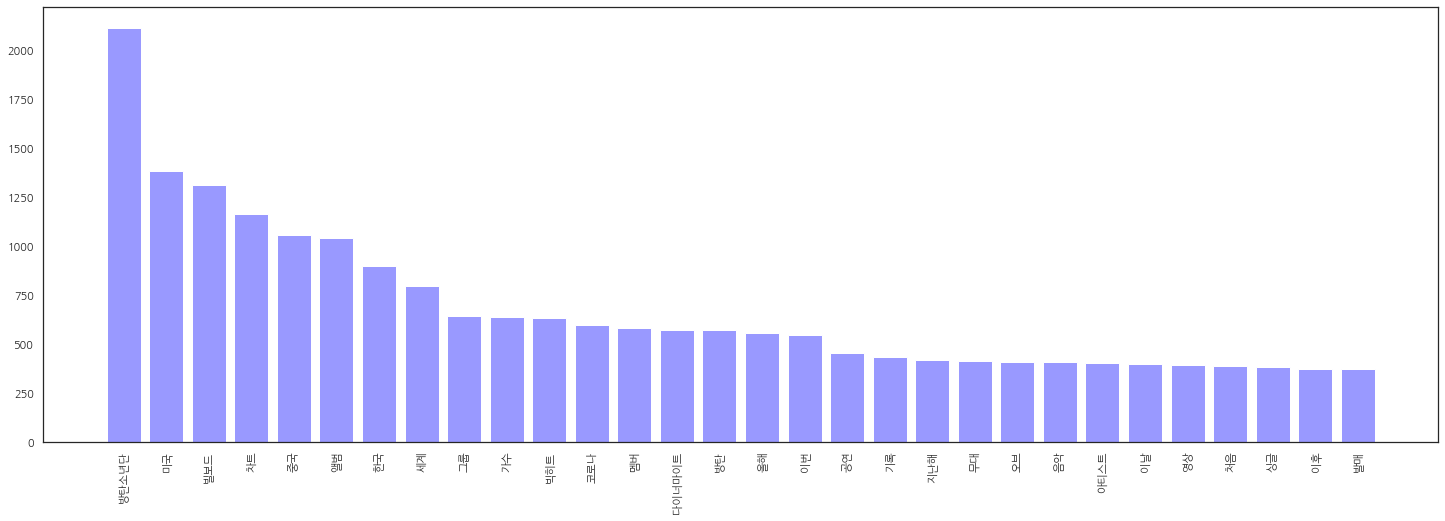

In [21]:
# rhino
words_list = [word for sent in data_df['token_rhino'] for word in sent]
print(words_list[:20])
vocab = Counter(words_list)
display_voca_count(pd.Series(vocab.most_common(100)), voca_num=30, figsize=(25,8))

# 문서유사도

문서유사도를 확인하기 위해 article original과 rhinoMorph를 활용해 토큰화한 단어를 CountVectorizer와 TfidifVectorizer를 활용하여 BoW를 만들고자 한다.  
이후 이를 통해 Cosine similarity를 확인하고자 한다.  

In [22]:
# CountVectorizer : sklearn 제공
# - max_df: 전체 문서에 걸쳐서 너무 높은 빈도수를 가지는 단어를 제외하기 위함 
# - min_df: 전체 문서에 걸쳐서 너무 낮은 빈도수를 가지는 단어를 제외하기 위함
# - max_features : 추출하는 feature의 개수 제한. 정수 지정
cnt_vect = CountVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)

--- cosine similarity CountVectorizer ( article_original ) ---
<class 'sklearn.feature_extraction.text.CountVectorizer'> : (853, 2931)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.23103443 0.17720436 ... 0.17610868 0.01644546 0.08895774]
 [0.23103443 1.         0.16872369 ... 0.15466178 0.06459093 0.05324024]
 [0.17720436 0.16872369 1.         ... 0.11416609 0.03753145 0.16782766]
 ...
 [0.17610868 0.15466178 0.11416609 ... 1.         0.06065204 0.13637945]
 [0.01644546 0.06459093 0.03753145 ... 0.06065204 1.         0.06632042]
 [0.08895774 0.05324024 0.16782766 ... 0.13637945 0.06632042 1.        ]]


--- cosine similarity CountVectorizer ( rhinoMorph ) ---
<class 'sklearn.feature_extraction.text.CountVectorizer'> : (853, 1567)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.25954955 0.24509473 ... 0.29599735 0.03942083 0.17418432]
 [0.25954955 1.         0.33318039 ... 0.21448551 0.01075829 0.16997871]
 [0.24509473 0.33318039 1.         ... 0.14343096 0.02606873 0.27226002]
 

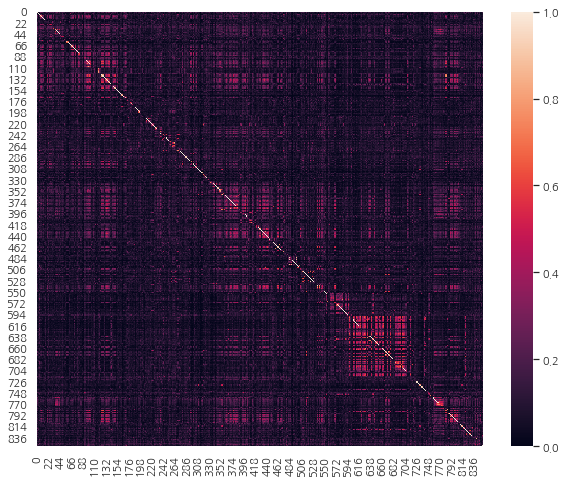

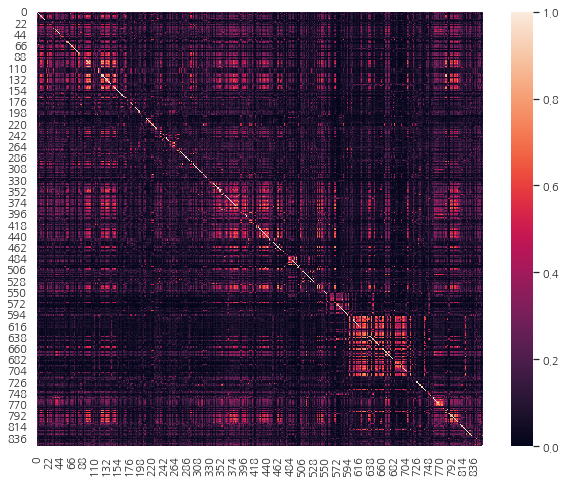

In [23]:
# # fit CountVectorizer - article_original
print('--- cosine similarity CountVectorizer ( article_original ) ---')
display_cosim(cnt_vect , data_df.article_original, figsize=(10,8))

# # fit CountVectorizer - rhinoMorph
print('\n\n--- cosine similarity CountVectorizer ( rhinoMorph ) ---')
display_cosim(cnt_vect, data_df.token_rhino, figsize=(10,8))

In [24]:
# TfidfVectorizer
# - tokenizer = LemNormalize 표준화, 사전(dic)에 기반한 표준화 
tfidf_vect = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=10, max_df=2000)

--- cosine similarity TfidfVectorizer ( article_original ) ---
<class 'sklearn.feature_extraction.text.TfidfVectorizer'> : (853, 3640)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.13880607 0.12836656 ... 0.12508095 0.00541618 0.04404543]
 [0.13880607 1.         0.05756596 ... 0.07146039 0.03515314 0.01571773]
 [0.12836656 0.05756596 1.         ... 0.06536203 0.01461246 0.09618829]
 ...
 [0.12508095 0.07146039 0.06536203 ... 1.         0.04357982 0.07216031]
 [0.00541618 0.03515314 0.01461246 ... 0.04357982 1.         0.0391614 ]
 [0.04404543 0.01571773 0.09618829 ... 0.07216031 0.0391614  1.        ]]


--- cosine similarity TfidfVectorizer ( rhinoMorph ) ---
<class 'sklearn.feature_extraction.text.TfidfVectorizer'> : (853, 2213)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.17226535 0.15075869 ... 0.18259783 0.01712649 0.06649991]
 [0.17226535 1.         0.12111563 ... 0.09505775 0.0018393  0.09050406]
 [0.15075869 0.12111563 1.         ... 0.07660435 0.01752608 0.17299849]
 

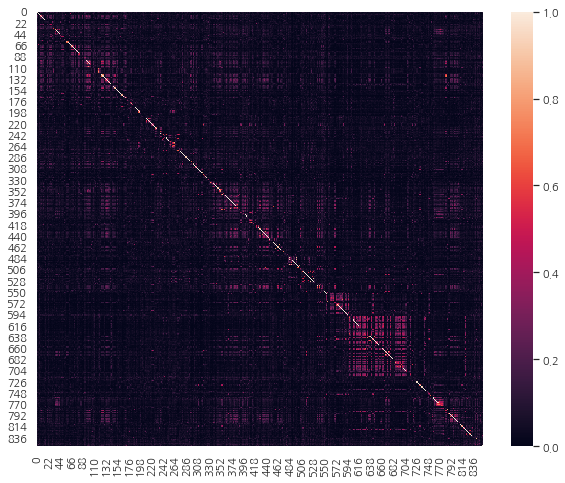

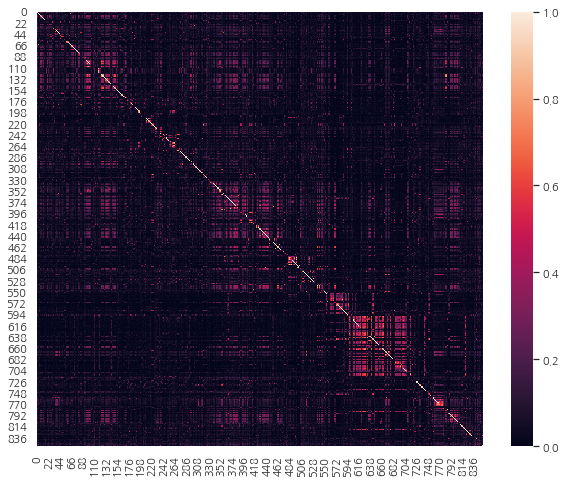

In [25]:
# # cosine similarity - article_original (TfidfVectorizer)
print('--- cosine similarity TfidfVectorizer ( article_original ) ---')
display_cosim(tfidf_vect , data_df.article_original, figsize=(10,8))

# # cosine similarity - rhinoMorph (TfidfVectorizer)
print('\n\n--- cosine similarity TfidfVectorizer ( rhinoMorph ) ---')
display_cosim(tfidf_vect, data_df.token_rhino, figsize=(10,8))

article_original 문서보다는 rhinoMorph로 토큰화된 문서가 문서유사도를 보다 선명하게 나타납니다.  
또한 CountVectorizer가 TfidfVecotrizer보다 문서유사도로 관계성 높은 그룹을 잘 나타내는 것으로 관찰됩니다.

# 토픽 모델링(LDA)으로 그룹화
- Latent Dirichlet Allocation
- 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합할 확률로 추정하여 토픽 추출
- 문서들이 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률분포에 기반하여 단어를 생성한다고 가정함.

<br></br>

- 사용자 알고리즘 지정사항: 토픽 개수
- 모든 문서의 모든 단어에 대하여 아래 사항 반복 진행
    - 어떤 문서의 각 단어 w는 자신은 잘못된 토픽에 할당되어져 있지만, 다른 단어들은 전부 올바른 토픽에 할당되어져 있는 상태라고 가정.
    - 이에 따라 단어 w는 아래 두가지 기준에 따라 토픽 재할당
        - 문서 d의 단어들 중 토픽 t에 해당하는 단어 비율
        - 단어 w를 갖고 있는 모든 문서들 중 토픽 t가 할당된 비율

## 적정 토픽 수 추정

## 1. gensim LDA
- dictionary : (전체 단어 정수 인덱스, 단어)
- corpus : 문서 별 단어 정수 인코딩 
    - (단어의 정수 인코딩 값,해당 뉴스에서의 해당 단어의 빈도수)



------
Number of unique tokens: 2637
type: <class 'gensim.corpora.dictionary.Dictionary'> 
 Dictionary(2637 unique tokens: ['강남스타일', '거대', '곳곳', '공동', '녹화']...)


Number of documents: 853
corpus type: <class 'list'> , corpus[0] type: <class 'list'>





=== coherence_values ===

 [0.5157662228344853, 0.5240214180081325, 0.5164017372368848, 0.48247876946690976, 0.5302128336820462, 0.48923257652035324, 0.49909000409219395, 0.5185775523920229, 0.4871850923514179]


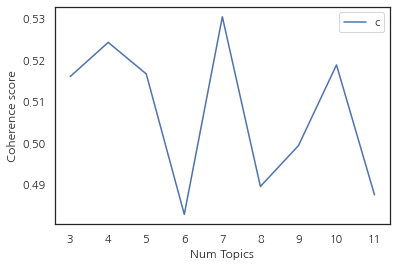

In [26]:
proper_num_list = get_gensim_numtopics(data_df.token_rhino, start=3, limit=12, step=1)

In [27]:
proper_num_list

[7, 4, 10, 5, 3]

In [28]:
topic_list = []
for i in tqdm_notebook(proper_num_list):
    ldamodel, corpus, dictionary = gensimLDA(data_df['token_rhino'],i)
    topic_list.append({'topic_num':i, 'ldamodel':ldamodel, 'corpus':corpus, 'dictionary':dictionary})



------
Number of unique tokens: 2637
type: <class 'gensim.corpora.dictionary.Dictionary'> 
 Dictionary(2637 unique tokens: ['강남스타일', '거대', '곳곳', '공동', '녹화']...)


Number of documents: 853
corpus type: <class 'list'> , corpus[0] type: <class 'list'>


-- topic --
(0, '0.009*"패션" + 0.005*"청약" + 0.005*"이태원" + 0.004*"삼성전자"')
(1, '0.005*"오피셜" + 0.004*"투표" + 0.003*"대구" + 0.003*"어깨"')
(2, '0.009*"작가" + 0.009*"미술" + 0.009*"전시" + 0.007*"중고"')
(3, '0.005*"이태원" + 0.004*"패션" + 0.003*"어워드" + 0.003*"중국인"')
(4, '0.007*"병역특례" + 0.007*"효과" + 0.004*"청와대" + 0.004*"공정"')
(5, '0.006*"경찰" + 0.005*"실물" + 0.005*"케이팝" + 0.005*"시위"')
(6, '0.004*"카페" + 0.004*"현대차" + 0.004*"공모" + 0.004*"제임스"')


------
Number of unique tokens: 2637
type: <class 'gensim.corpora.dictionary.Dictionary'> 
 Dictionary(2637 unique tokens: ['강남스타일', '거대', '곳곳', '공동', '녹화']...)


Number of documents: 853
corpus type: <class 'list'> , corpus[0] type: <class 'list'>


-- topic --
(0, '0.006*"패션" + 0.004*"삼성전자" + 0.003*"청약" + 0.003*"카페"')

In [29]:
# LDA 시각화하기
# - 각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줍니다. 
# - 만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다. 
vis = []
for i in tqdm_notebook(range(len(topic_list))):
    pyLDAvis.enable_notebook()
    ldamodel = topic_list[i]['ldamodel']
    corpus = topic_list[i]['corpus']
    dictionary = topic_list[i]['dictionary']
    vis.append(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary))

In [30]:
idx = 0
print('\n --- topic num:', proper_num_list[idx],'\n\n')
pyLDAvis.display(vis[idx])


 --- topic num: 7 




In [31]:
idx = 1
print('\n --- topic num:', proper_num_list[idx],'\n\n')
pyLDAvis.display(vis[idx])


 --- topic num: 4 




In [32]:
idx = 2
print('\n --- topic num:', proper_num_list[idx],'\n\n')
pyLDAvis.display(vis[idx])


 --- topic num: 10 




In [33]:
idx = 3
print('\n --- topic num:', proper_num_list[idx],'\n\n')
pyLDAvis.display(vis[idx])


 --- topic num: 5 




In [34]:
idx = 4
print('\n --- topic num:', proper_num_list[idx],'\n\n')
pyLDAvis.display(vis[idx])


 --- topic num: 3 




## 2. sklearn LDA - CoutVectorizer, TfdifVectorizer

### CountVectorizer

In [35]:
# 토픽 개수: 5
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 5)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(5, 1567)
Topic # 0
[('빌보드', 1171.59), ('차트', 1156.59), ('앨범', 983.84), ('방탄소년단', 979.53), ('미국', 735.1), ('다이너마이트', 506.05), ('가수', 407.06), ('기록', 397.84), ('발매', 360.4), ('싱글', 348.83), ('그룹', 320.34), ('한국', 315.33), ('오브', 308.16), ('정상', 297.62), ('세계', 269.03), ('판매량', 264.0), ('스트리밍', 230.79), ('처음', 226.47), ('순위', 219.09), ('트위터', 213.4)]
Topic # 1
[('병역', 212.2), ('코로나', 153.66), ('대통령', 147.45), ('의원', 139.68), ('문제', 123.95), ('연기', 121.19), ('분야', 120.53), ('공연', 113.42), ('병역특례', 108.2), ('장관', 104.84), ('한류', 88.42), ('병역법', 85.2), ('국민', 78.91), ('미술', 76.72), ('정부', 72.91), ('방탄', 72.6), ('국가', 70.93), ('국회', 70.27), ('방탄소년단', 69.52), ('예정', 69.42)]
Topic # 2
[('빅히트', 579.0), ('방탄소년단', 332.15), ('세계', 242.44), ('청년', 242.06), ('멤버', 206.75), ('온라인', 182.12), ('시장', 172.79), ('대표', 171.81), ('상장', 158.57), ('지난해', 156.44), ('국내', 149.91), ('공연', 139.79), ('콘서트', 137.86), ('영상', 137.4), ('매출', 133.03), ('엔터테인먼트', 132.15), ('사람', 126.18), ('코로나', 125.59), ('브랜드', 122.88)

In [36]:
# 토픽 개수: 6
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 6)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(6, 1567)
Topic # 0
[('빌보드', 1184.56), ('차트', 1154.91), ('앨범', 995.26), ('방탄소년단', 971.35), ('미국', 726.77), ('다이너마이트', 502.68), ('가수', 407.05), ('기록', 389.53), ('싱글', 360.81), ('발매', 355.11), ('그룹', 320.71), ('오브', 304.92), ('한국', 303.15), ('정상', 297.06), ('판매량', 263.79), ('세계', 257.97), ('처음', 231.23), ('스트리밍', 224.01), ('순위', 219.11), ('연속', 215.21)]
Topic # 1
[('병역', 211.12), ('대통령', 155.4), ('의원', 140.38), ('문제', 121.69), ('분야', 109.86), ('연기', 109.45), ('병역특례', 108.17), ('장관', 104.54), ('병역법', 85.17), ('한류', 76.57), ('국민', 74.32), ('국회', 70.86), ('정치', 69.28), ('특례', 69.17), ('정부', 66.11), ('최고위원', 64.17), ('개정안', 61.17), ('이날', 60.33), ('공정', 59.27), ('더불어민주당', 57.17)]
Topic # 2
[('빅히트', 554.31), ('청년', 214.76), ('방탄소년단', 183.32), ('시장', 169.4), ('대표', 168.0), ('상장', 157.58), ('멤버', 143.47), ('지난해', 133.11), ('매출', 132.84), ('엔터테인먼트', 125.08), ('브랜드', 123.61), ('국내', 119.83), ('패션', 110.86), ('공모', 105.17), ('회사', 103.34), ('광고', 97.82), ('기준', 97.46), ('인기', 95.69), ('글로벌', 95.11

In [37]:
# 토픽 개수: 7
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 7)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(7, 1567)
Topic # 0
[('빌보드', 1161.54), ('차트', 1153.87), ('앨범', 979.07), ('방탄소년단', 927.01), ('미국', 642.13), ('다이너마이트', 494.31), ('기록', 393.81), ('가수', 387.11), ('발매', 356.83), ('싱글', 350.32), ('오브', 306.57), ('그룹', 302.46), ('정상', 296.89), ('한국', 272.58), ('판매량', 263.28), ('스트리밍', 228.56), ('세계', 228.02), ('처음', 217.16), ('순위', 216.08), ('라디오', 208.97)]
Topic # 1
[('병역', 212.14), ('의원', 140.45), ('문제', 112.92), ('연기', 109.25), ('병역특례', 108.14), ('분야', 104.82), ('장관', 103.91), ('병역법', 85.14), ('국회', 70.97), ('특례', 69.14), ('최고위원', 64.14), ('정치', 61.34), ('개정안', 61.14), ('입영', 57.66), ('더불어민주당', 57.14), ('한류', 56.29), ('대중문화예술인', 56.14), ('대중문화예술', 56.14), ('이날', 54.76), ('국가', 54.15)]
Topic # 2
[('청년', 280.13), ('대통령', 207.78), ('미국', 207.58), ('방탄소년단', 203.69), ('한국', 165.94), ('세계', 163.72), ('사람', 162.63), ('트위터', 124.09), ('마음', 117.5), ('패션', 115.24), ('이야기', 91.35), ('메시지', 85.68), ('멤버', 84.13), ('미래', 79.4), ('지금', 78.75), ('스타', 76.04), ('노래', 75.02), ('케이팝', 74.21), ('세대', 72.9

In [38]:
# 토픽 개수: 8
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 8)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(8, 1567)
Topic # 0
[('차트', 1136.31), ('빌보드', 1122.77), ('앨범', 966.38), ('방탄소년단', 865.96), ('미국', 592.04), ('다이너마이트', 493.43), ('기록', 384.96), ('가수', 376.41), ('발매', 355.56), ('싱글', 345.41), ('오브', 303.37), ('정상', 292.41), ('그룹', 289.87), ('판매량', 263.94), ('한국', 249.51), ('스트리밍', 222.0), ('순위', 209.25), ('뮤직비디오', 209.19), ('처음', 204.91), ('세계', 203.31)]
Topic # 1
[('병역', 211.1), ('의원', 143.12), ('문제', 108.29), ('병역특례', 108.12), ('연기', 108.09), ('장관', 103.47), ('분야', 90.27), ('병역법', 85.12), ('국회', 73.84), ('특례', 69.12), ('최고위원', 64.12), ('개정안', 61.12), ('입영', 57.68), ('더불어민주당', 57.12), ('대중문화예술인', 56.12), ('대중문화예술', 56.12), ('정치', 53.95), ('이날', 51.31), ('주장', 50.33), ('병무청', 49.12)]
Topic # 2
[('청년', 279.05), ('대통령', 196.51), ('방탄소년단', 152.24), ('패션', 125.76), ('마음', 109.2), ('멤버', 83.91), ('메시지', 81.8), ('세계', 77.74), ('미래', 76.79), ('브랜드', 75.14), ('행사', 74.48), ('노래', 70.84), ('지금', 70.06), ('미국', 67.74), ('졸업식', 60.12), ('유튜브', 58.16), ('힘들', 56.66), ('청와대', 56.55), ('세대', 56.23), 

In [39]:
# 토픽 개수: 9
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 9)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(9, 1567)
Topic # 0
[('차트', 1147.84), ('빌보드', 1130.72), ('앨범', 967.5), ('방탄소년단', 911.1), ('미국', 602.59), ('다이너마이트', 497.14), ('가수', 379.57), ('기록', 378.25), ('발매', 356.54), ('싱글', 347.1), ('오브', 303.28), ('정상', 295.2), ('그룹', 292.93), ('판매량', 258.75), ('한국', 249.97), ('스트리밍', 225.05), ('순위', 213.38), ('처음', 211.02), ('라디오', 207.98), ('세계', 205.39)]
Topic # 1
[('병역', 212.11), ('의원', 140.5), ('연기', 108.23), ('병역특례', 108.11), ('문제', 107.58), ('장관', 103.42), ('분야', 93.45), ('병역법', 85.11), ('국회', 71.0), ('특례', 69.11), ('최고위원', 64.11), ('개정안', 61.11), ('입영', 57.77), ('더불어민주당', 57.11), ('대중문화예술인', 56.11), ('대중문화예술', 56.11), ('정치', 55.13), ('주장', 51.43), ('이날', 51.36), ('활동', 51.23)]
Topic # 2
[('청년', 273.63), ('빅히트', 193.27), ('대통령', 190.44), ('방탄소년단', 170.77), ('멤버', 120.87), ('상장', 103.26), ('마음', 78.98), ('대표', 73.21), ('미래', 61.45), ('행사', 61.17), ('졸업식', 60.11), ('메시지', 59.09), ('방시혁', 56.2), ('방탄', 55.99), ('청와대', 55.7), ('엔터테인먼트', 53.34), ('지금', 52.21), ('공정', 52.07), ('대한민국', 50.38), 

In [40]:
# 토픽 개수: 10
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA_cntvect(data_df.token_rhino, 10)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(10, 1567)
Topic # 0
[('방탄소년단', 464.93), ('앨범', 404.44), ('미국', 219.71), ('뮤직비디오', 205.13), ('트위터', 197.03), ('세계', 176.37), ('가수', 173.18), ('유튜브', 160.07), ('오브', 150.9), ('슈가', 149.33), ('차트', 147.35), ('발매', 142.64), ('한국', 127.78), ('기록', 121.55), ('정규', 115.23), ('음악', 115.23), ('그룹', 108.12), ('일본', 97.15), ('신곡', 96.22), ('타이틀곡', 94.79)]
Topic # 1
[('병역', 209.36), ('의원', 143.1), ('병역특례', 108.1), ('문제', 104.88), ('장관', 103.59), ('연기', 102.51), ('분야', 93.5), ('병역법', 85.1), ('국회', 72.22), ('특례', 69.1), ('최고위원', 64.1), ('개정안', 61.1), ('더불어민주당', 57.1), ('입영', 57.01), ('대중문화예술인', 56.1), ('대중문화예술', 56.1), ('정치', 54.53), ('이날', 51.25), ('주장', 50.35), ('병무청', 49.1)]
Topic # 2
[('청년', 270.03), ('대통령', 200.62), ('방탄소년단', 151.74), ('마음', 70.85), ('멤버', 61.85), ('행사', 61.52), ('졸업식', 60.1), ('미래', 58.23), ('청와대', 56.76), ('빅히트', 56.75), ('메시지', 54.3), ('공정', 52.52), ('미국', 51.9), ('세계', 51.74), ('방탄', 51.68), ('대한민국', 51.06), ('노래', 50.41), ('문재인', 49.42), ('유튜브', 43.82), ('대표', 43.48)]
Top

### TF-IDF Vectorizer

In [41]:
# 토픽 개수: 5
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 5)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(5, 1567)
Topic # 0
[('방탄소년단', 48.14), ('차트', 47.32), ('빌보드', 47.16), ('앨범', 41.04), ('미국', 32.36), ('다이너마이트', 27.7), ('가수', 20.97), ('기록', 19.53), ('오브', 19.07), ('발매', 19.04), ('세계', 19.02), ('그룹', 18.68), ('한국', 18.55), ('싱글', 18.49), ('무대', 18.28), ('뮤직비디오', 17.01), ('노래', 15.92), ('후보', 15.78), ('올해', 15.59), ('유튜브', 15.48)]
Topic # 1
[('병역', 12.3), ('의원', 9.72), ('병역특례', 8.47), ('연기', 7.01), ('장관', 6.91), ('병역법', 6.23), ('최고위원', 5.92), ('특례', 5.35), ('국회', 5.15), ('분야', 4.99), ('개정안', 4.99), ('문제', 4.92), ('입영', 4.59), ('더불어민주당', 4.58), ('대중문화예술인', 4.57), ('대중문화예술', 4.48), ('입대', 4.32), ('병무청', 4.29), ('우수자', 4.13), ('정치', 4.01)]
Topic # 2
[('빅히트', 26.07), ('공연', 13.82), ('콘서트', 11.57), ('상장', 10.55), ('코로나', 7.58), ('공모', 7.52), ('대표', 7.42), ('매출', 7.33), ('엔터테인먼트', 6.6), ('온라인', 6.34), ('미술', 6.22), ('광고', 6.2), ('투어', 5.98), ('주식', 5.95), ('작가', 5.95), ('서울', 5.9), ('방탄소년단', 5.83), ('시장', 5.79), ('전시', 5.67), ('회사', 5.65)]
Topic # 3
[('중국', 41.75), ('네티즌', 11.01), ('발언', 8.92

In [42]:
# 토픽 개수: 6
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 6)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(6, 1567)
Topic # 0
[('방탄소년단', 51.45), ('빌보드', 47.3), ('차트', 47.28), ('앨범', 41.01), ('미국', 33.0), ('다이너마이트', 27.68), ('세계', 22.24), ('가수', 21.36), ('한국', 19.8), ('기록', 19.79), ('그룹', 19.74), ('오브', 19.52), ('발매', 19.01), ('싱글', 18.47), ('코로나', 18.19), ('무대', 17.83), ('올해', 17.13), ('뮤직비디오', 16.98), ('멤버', 16.54), ('노래', 15.89)]
Topic # 1
[('병역', 11.74), ('의원', 9.0), ('병역특례', 8.44), ('연기', 7.17), ('장관', 6.28), ('병역법', 6.2), ('특례', 5.32), ('최고위원', 5.2), ('개정안', 4.96), ('국회', 4.94), ('분야', 4.86), ('입영', 4.54), ('대중문화예술인', 4.53), ('문제', 4.48), ('대중문화예술', 4.45), ('더불어민주당', 4.29), ('입대', 4.27), ('병무청', 4.25), ('우수자', 4.1), ('정치', 3.82)]
Topic # 2
[('빅히트', 21.8), ('청년', 10.85), ('상장', 10.36), ('공모', 7.49), ('주식', 5.93), ('졸업식', 5.42), ('대통령', 5.39), ('대표', 4.87), ('주가', 4.79), ('방시혁', 4.4), ('엔터테인먼트', 3.92), ('청약', 3.91), ('공모주', 3.74), ('회사', 3.73), ('사업', 3.71), ('영업이익', 3.68), ('의장', 3.39), ('빅히트엔터테인먼트', 3.37), ('투자자', 3.27), ('기준', 3.11)]
Topic # 3
[('중국', 41.92), ('네티즌', 10.93), ('발언', 8

In [43]:
# 토픽 개수: 7
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 7)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(7, 1567)
Topic # 0
[('빌보드', 47.28), ('차트', 47.25), ('방탄소년단', 46.45), ('앨범', 40.93), ('미국', 32.17), ('다이너마이트', 27.65), ('가수', 20.58), ('기록', 19.61), ('한국', 18.99), ('발매', 18.98), ('세계', 18.89), ('그룹', 18.82), ('오브', 18.69), ('싱글', 18.45), ('무대', 18.25), ('뮤직비디오', 16.95), ('올해', 16.88), ('후보', 15.96), ('정상', 15.41), ('노래', 15.23)]
Topic # 1
[('병역', 12.06), ('의원', 9.04), ('병역특례', 8.41), ('연기', 7.08), ('장관', 6.25), ('병역법', 6.17), ('최고위원', 5.89), ('특례', 5.3), ('국회', 4.96), ('개정안', 4.93), ('분야', 4.9), ('문제', 4.58), ('더불어민주당', 4.54), ('서울시', 4.52), ('대중문화예술인', 4.51), ('입영', 4.5), ('대중문화예술', 4.43), ('입대', 4.24), ('병무청', 4.23), ('우수자', 4.08)]
Topic # 2
[('빅히트', 20.62), ('상장', 10.36), ('공모', 7.47), ('주식', 5.9), ('청년', 5.15), ('주가', 4.81), ('이태원', 4.46), ('방시혁', 4.38), ('엔터테인먼트', 4.33), ('대표', 4.32), ('대통령', 4.28), ('청약', 3.75), ('공모주', 3.58), ('회사', 3.46), ('의장', 3.39), ('사업', 3.38), ('기준', 3.2), ('영업이익', 3.18), ('매출', 2.87), ('빅히트엔터테인먼트', 2.8)]
Topic # 3
[('중국', 41.55), ('네티즌', 10.96), ('발언', 

In [44]:
# 토픽 개수: 8
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 8)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(8, 1567)
Topic # 0
[('차트', 47.11), ('빌보드', 46.95), ('방탄소년단', 43.46), ('앨범', 40.06), ('미국', 31.47), ('다이너마이트', 27.59), ('가수', 20.49), ('기록', 19.23), ('발매', 18.78), ('오브', 18.45), ('싱글', 18.35), ('한국', 17.63), ('그룹', 17.23), ('뮤직비디오', 16.94), ('무대', 16.11), ('후보', 15.9), ('세계', 15.65), ('정상', 15.31), ('올해', 15.22), ('판매량', 14.38)]
Topic # 1
[('병역', 11.53), ('의원', 9.06), ('병역특례', 8.4), ('연기', 6.54), ('장관', 6.19), ('병역법', 6.16), ('최고위원', 5.87), ('특례', 5.28), ('국회', 4.97), ('개정안', 4.92), ('분야', 4.81), ('더불어민주당', 4.53), ('문제', 4.52), ('대중문화예술인', 4.49), ('입영', 4.48), ('대중문화예술', 4.41), ('병무청', 4.21), ('우수자', 4.06), ('입대', 3.9), ('정치', 3.8)]
Topic # 2
[('이태원', 3.72), ('검사', 2.24), ('정국', 2.19), ('사회적', 2.12), ('거스', 1.76), ('방문', 1.67), ('거리', 1.47), ('대변인', 1.47), ('음성', 1.16), ('지침', 1.11), ('노력', 0.97), ('페이스북', 0.94), ('아이돌', 0.87), ('모임', 0.86), ('자발적', 0.8), ('당사', 0.8), ('발생', 0.76), ('확진자', 0.74), ('사망', 0.72), ('대통령', 0.63)]
Topic # 3
[('중국', 40.8), ('네티즌', 10.74), ('발언', 8.59), ('한국전

In [45]:
# 토픽 개수: 9
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 9)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(9, 1567)
Topic # 0
[('차트', 46.95), ('빌보드', 45.28), ('앨범', 40.21), ('방탄소년단', 33.53), ('다이너마이트', 27.54), ('미국', 21.28), ('발매', 18.6), ('싱글', 18.32), ('기록', 18.05), ('오브', 17.81), ('가수', 17.81), ('뮤직비디오', 16.12), ('정상', 14.81), ('그룹', 14.73), ('판매량', 14.42), ('연속', 13.14), ('순위', 12.86), ('노래', 12.84), ('라디오', 12.47), ('스트리밍', 12.32)]
Topic # 1
[('병역', 11.86), ('의원', 9.57), ('병역특례', 8.38), ('연기', 6.36), ('장관', 6.35), ('병역법', 6.14), ('최고위원', 5.85), ('특례', 5.26), ('국회', 5.22), ('개정안', 4.9), ('분야', 4.68), ('대중문화예술인', 4.48), ('입영', 4.46), ('대중문화예술', 4.4), ('문제', 4.39), ('병무청', 4.2), ('더불어민주당', 4.15), ('우수자', 4.04), ('입대', 3.91), ('정치', 3.64)]
Topic # 2
[('빅히트', 28.2), ('공연', 17.27), ('코로나', 14.2), ('콘서트', 13.77), ('방탄소년단', 13.13), ('영상', 12.48), ('서울', 11.15), ('상장', 10.91), ('멤버', 10.7), ('세계', 9.74), ('온라인', 9.09), ('트위터', 8.36), ('대표', 8.25), ('엔터테인먼트', 7.9), ('시장', 7.47), ('공모', 7.44), ('예정', 7.32), ('매출', 7.27), ('국내', 7.17), ('지난해', 6.79)]
Topic # 3
[('중국', 41.29), ('후보', 15.18), ('한국'

In [47]:
# 토픽 개수: 10
lda_model, tfidf_matrix, tfidf_vect, topic_list = sklLDA_tfidf(data_df.token_rhino, 10)
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(10, 1567)
Topic # 0
[('베스트', 5.76), ('인종차별', 3.49), ('흑인', 2.59), ('경찰', 2.51), ('어깨', 2.46), ('플로이드', 2.43), ('괜찮', 2.36), ('시위', 2.33), ('조지', 2.31), ('시청', 2.21), ('응원', 2.09), ('수술', 1.82), ('누적', 1.53), ('랭킹', 1.51), ('반대', 1.42), ('이탈리아', 1.37), ('케이팝', 1.37), ('장기화', 1.33), ('생명', 1.29), ('폭력', 1.26)]
Topic # 1
[('병역', 11.67), ('의원', 9.56), ('병역특례', 8.37), ('연기', 6.97), ('장관', 6.25), ('병역법', 6.13), ('최고위원', 5.84), ('특례', 5.25), ('국회', 5.1), ('개정안', 4.89), ('분야', 4.66), ('더불어민주당', 4.51), ('입영', 4.49), ('대중문화예술인', 4.47), ('대중문화예술', 4.39), ('문제', 4.26), ('병무청', 4.19), ('우수자', 4.03), ('입대', 3.88), ('정치', 3.73)]
Topic # 2
[('빅히트', 28.73), ('코로나', 19.26), ('공연', 18.81), ('방탄소년단', 16.31), ('멤버', 15.12), ('콘서트', 15.12), ('세계', 12.52), ('영상', 11.64), ('서울', 11.35), ('상장', 10.9), ('온라인', 9.38), ('대표', 9.11), ('엔터테인먼트', 8.78), ('무대', 8.31), ('시장', 8.2), ('작가', 8.13), ('예정', 7.88), ('국내', 7.86), ('유튜브', 7.5), ('모습', 7.43)]
Topic # 3
[('앨범', 35.15), ('차트', 27.55), ('빌보드', 22.84), ('방탄소년단', 

gensim 패키지와 sklearn 패키지(Count Vectorizer, TF-IDF Vactorizer)에서 제공하는 LDA(Latent Dirichlet Allocation) 모델을 활용해 토픽을 5~8가지로 나눴을 때의 분포도를 pyLDAvis 패키지를 활용하여 시각화를 통해 확인하였습니다.  